Lecturer: Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Ziwei Huang, Rita González Márquez

Summer term 2023

Name: FILL IN YOUR NAMES HERE

# Neural Data Science Project 01

## Working with Calcium data

In the following project you will recieve a data set, along with a set of questions. Use the methods that you have learned throughout this course to explore the data and to answer the questions. You are free to use tools, resources and libraries as you see fit. Use comments and markdown cells to document your thought process and to explain your reasoning. We encourage you to compare different algorithms or to implement state of the art solutions. The notebook should be self contained, although you may offload some functions to a `utils.py`. The notebook should be concluded with a final summary / conclusions section.

In [1]:
# import packages here
from pathlib import Path

import utils_project1 as utils

import numpy as np
import pandas as pd
import jupyter_black
import matplotlib.pyplot as plt
import matplotlib.patches as mp

jupyter_black.load()

## Context
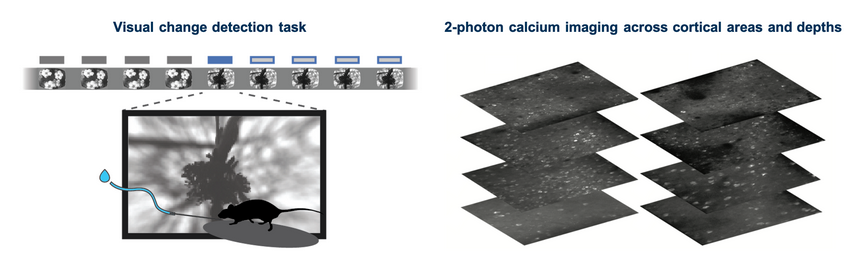

The data set that goes along with this notebook was recorded using in vivo 2-photon calcium imaging to measure the activity of genetically identified neurons in the visual cortex of mice performing a go/no-go visual change detection task. The data recordings stem from primary visual cortex and a GCaMP6f indicator was used. The data was recorded as follows.

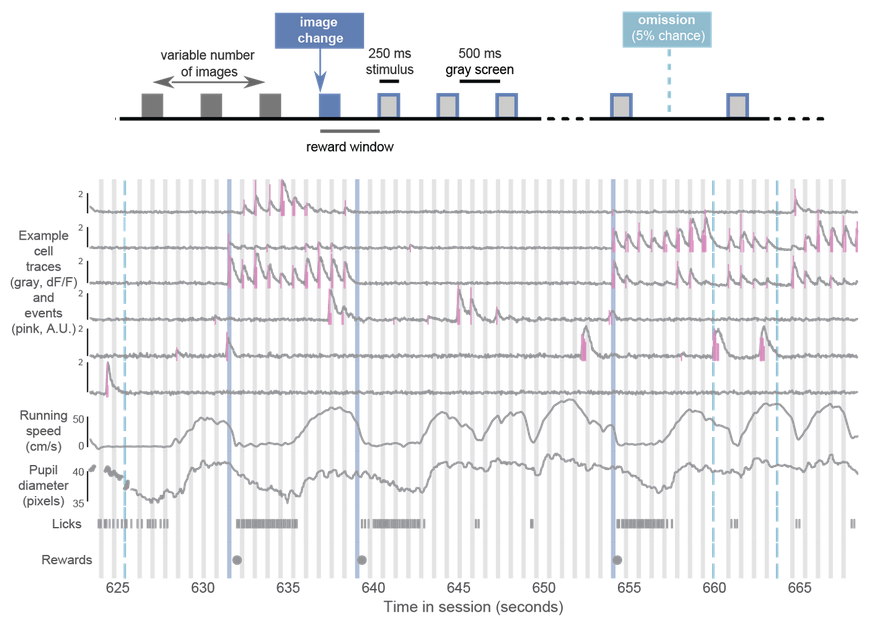

The data consists of:
- the preprocessed activity traces (df/f)
- the stimulus metadata
- the ROI masks for each cell
- a maximum activity projection of all ROIs
- running speed
- table of stimulus epochs

You will only work with a drifting grating stimulus.

Since the experiments were performed in sequence the calcium recordings that you receive also contain some other stimulus modalities (see `data["stim_epoch_table"]`). You can ignore these sections of the time-series data during analysis. Not all the data provided has to be used, however it can be incorporated into your analysis.

In [2]:
# load data
def load_data(path="."):
    def array2df(d, key, cols):
        d[key] = pd.DataFrame(d[key], columns=cols)

    data = np.load(path + "/dff_data_dsi.npz", allow_pickle=True)
    data = dict(data)
    array2df(
        data,
        "stim_table",
        ["temporal_frequency", "orientation", "blank_sweep", "start", "end"],
    )
    array2df(data, "stim_epoch_table", ["stimulus", "start", "end"])

    return data


def print_info(data):
    data_iter = ((k, type(v), v.shape) for k, v in data.items())
    l = [f"[{k}] - {t}, - {s}" for k, t, s in data_iter]
    print("\n".join(l) + "\n")


data = load_data(path="../data/")
print(type(data))
print(data.keys())
print("Overview of the data")
print_info(data)
#
print(data["stim_epoch_table"])
print(data["stim_table"])
print(data["t"])

<class 'dict'>
dict_keys(['t', 'dff', 'stim_table', 'roi_masks', 'max_projection', 'running_speed', 'stim_epoch_table'])
Overview of the data
[t] - <class 'numpy.ndarray'>, - (115471,)
[dff] - <class 'numpy.ndarray'>, - (106, 115471)
[stim_table] - <class 'pandas.core.frame.DataFrame'>, - (628, 5)
[roi_masks] - <class 'numpy.ndarray'>, - (106, 512, 512)
[max_projection] - <class 'numpy.ndarray'>, - (512, 512)
[running_speed] - <class 'numpy.ndarray'>, - (2, 115471)
[stim_epoch_table] - <class 'pandas.core.frame.DataFrame'>, - (7, 3)

              stimulus  start     end
0    drifting_gratings    747   18775
1  natural_movie_three  19709   37767
2    natural_movie_one  38671   47699
3    drifting_gratings  48602   66630
4          spontaneous  66780   75697
5  natural_movie_three  75698   93756
6    drifting_gratings  94659  115215
     temporal_frequency  orientation  blank_sweep     start       end
0                   1.0        225.0          0.0     747.0     807.0
1               

## Downloading OOPSI alogrithm for the spike inference 
* Link to the Github repository: https://github.com/liubenyuan/py-oopsi
* Link to the paper: http://stat.columbia.edu/~liam/research/pubs/vogelstein-fast.pdf 
    * published in: Journal of Neurophysiology, 104(6): 3691-3704

In [3]:
download_url = "https://raw.githubusercontent.com/liubenyuan/py-oopsi/master/oopsi.py"
file_name = "oopsi.py"
if not Path(file_name).exists():
    !curl -L $download_url -o $file_name

In [4]:
import oopsi as ops

# Table of Contents
# Generate Table of Contents

# Table of Content: 
###  [01. Data Exploration](#data_exploration)
*  #### [1.1 First look at the distribution of the stimulus (orientations, time).](#displayedorientation)
*  #### [1.2 Display the maximum projection of the ROIs.](#maximum_projection)
*  #### [1.3 Display the roi masks.](#roi_masks)
*  #### [1.4 Display the df/f traces over time.](#displaydff)
*  #### [1.5 Visualize the traces where the drifting gratings were shown.](#displaydffdrifting)
*  #### [1.6 Visualize some active traces](#activetraces)
  
###  [02. Orientation selectiviy in DF/F](#orientation_selectivity)
###  [03. Orientation selectiviy in spikes](#orientation_selectivity_spikes)
###  [04. Orientation selectiviy in spikes - tuning curves](#orientation_selectivity_spikes_tuning_curves)
###  [05. Orientation selectiviy in spikes - temporal frequency](#orientation_selectivity_spikes_tuning_curves_alternative)

# 1. Data Exploration <a name="data_exploration"></a>

## 1.1 The displayed orientations are not equally distributed <a name="displayedorientation"></a>
*  We have around 75 trials for each orientation and 30 trials for the blank stimulus (which is 5 % of the trials).

Orientations: [  0.  45.  90. 135. 180. 225. 270. 315.  nan],
Counts Orientation: [75 75 75 74 75 75 75 74 30]

Temporal Frequencies: [ 1.  2.  4.  8. 15. nan],
Counts Temporal Frequencies:[120 120 119 120 119  30]

Blank Sweeps: [0. 1.],
Counts Black Sweeps: [598  30]


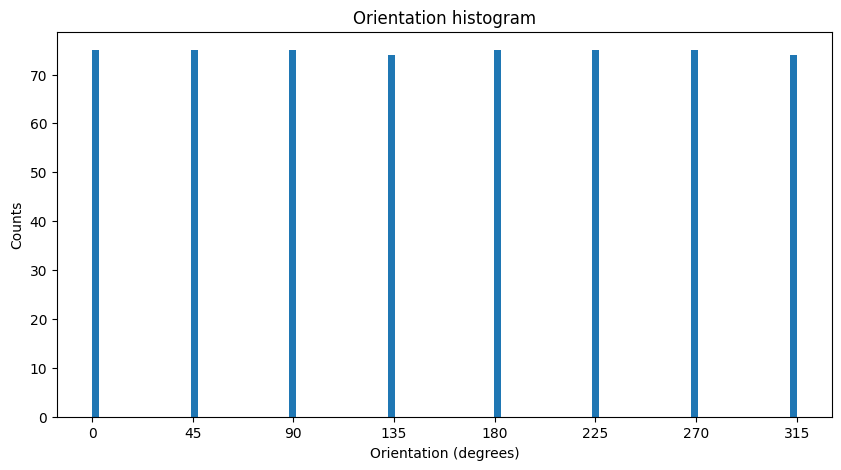

In [5]:
# ploting the orientation histogram
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.hist(data["stim_table"]["orientation"], bins=100)
ax.set_xlabel("Orientation (degrees)")
ax.set_ylabel("Counts")
ax.set_title("Orientation histogram")
ax.set_xticks(np.arange(0, 360, 45))
# print out the unique values and their counts for orientation, temporal frequency and blank sweeps
uniq, coutnts = np.unique(data["stim_table"]["orientation"], return_counts=True)
print(f"Orientations: {uniq},\nCounts Orientation: {coutnts}\n")
freqs, counts_freqs = np.unique(
    data["stim_table"]["temporal_frequency"], return_counts=True
)
print(f"Temporal Frequencies: {freqs},\nCounts Temporal Frequencies:{counts_freqs}\n")
blanks, counts_blanks = np.unique(data["stim_table"]["blank_sweep"], return_counts=True)
print(f"Blank Sweeps: {blanks},\nCounts Black Sweeps: {counts_blanks}")

### Not equally distributed over the three stimulus epochs!
We can infere this because in the stim_epoch_table we can see that the grating stimulus was shown 3 times, and we wanted to check if there were identical trials.

In [6]:
uniq, coutnts = np.unique(
    data["stim_table"]["orientation"][:200],
    return_counts=True,
)

print(f"Orientations and Counts for the first trial: {uniq}, {coutnts}\n")

uniq, coutnts = np.unique(
    data["stim_table"]["orientation"][200:400],
    return_counts=True,
)
print(f"Orientations and Counts for the second trial: {uniq}, {coutnts}\n")

uniq, coutnts = np.unique(
    data["stim_table"]["orientation"][400:627],
    return_counts=True,
)
print(f"Orientations and Counts for the thrid trial: {uniq}, {coutnts}\n")

Orientations and Counts for the first trial: [  0.  45.  90. 135. 180. 225. 270. 315.  nan], [26 25 22 25 24 29 18 19 12]

Orientations and Counts for the second trial: [  0.  45.  90. 135. 180. 225. 270. 315.  nan], [23 26 19 22 21 22 28 27 12]

Orientations and Counts for the thrid trial: [  0.  45.  90. 135. 180. 225. 270. 315.  nan], [26 24 34 27 29 24 29 28  6]



### Sampling rate is around 30 hz (30 frames per second), and stiumulus is 2 second long

In [7]:
# the sampling rate:
print(f"Unique values of the sampling rate: {1 / np.unique(np.diff(data['t']))}")
# the stimulus time:
print(
    f'Stimulus time: {data["t"][data["stim_table"]["end"][0].astype(int)] - data["t"][data["stim_table"]["start"][0].astype(int)]}'
)

Unique values of the sampling rate: [30.07518797 30.07518797 30.07518797 30.07518797 30.07518797 30.07518797
 30.07518797 30.07518797 30.07518797 30.07518797 30.07518797 30.06614552
 30.06614552 30.06614552 30.06614552 30.06614552 30.06614552 30.06614552
 30.06614552 30.06614552 30.06614552]
Stimulus time: 1.9952200000000033


## 1.2 Display the maximum projection of the ROIs. <a class="anchor" id="maximum_projection"></a>

* one plot with maximum projection of the ROIs and besides the mask of the ROIs

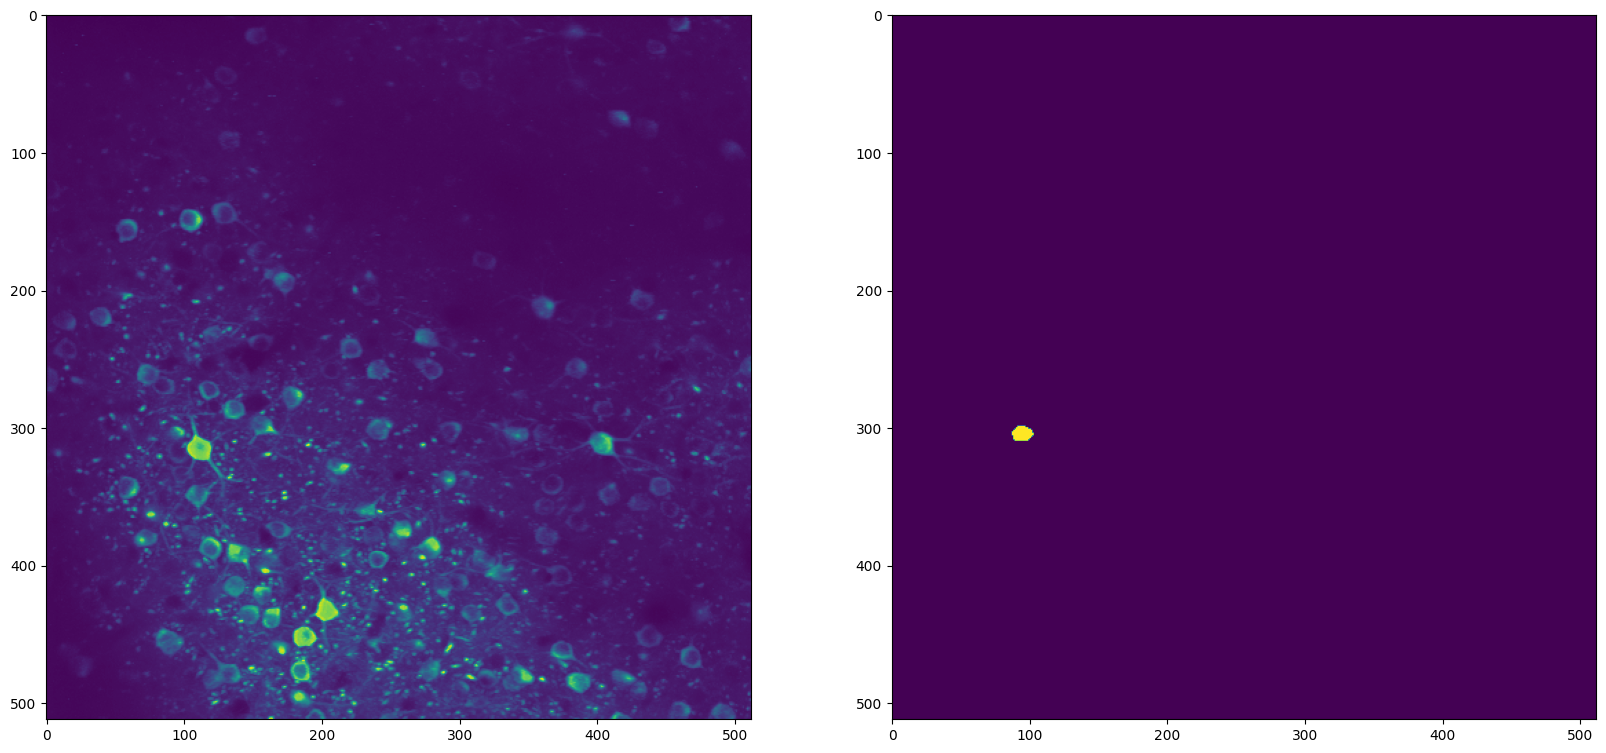

In [8]:
# plotting the max projection and the first ROI mask
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(data["max_projection"])
ax[1].imshow(data["roi_masks"][0, :, :])

## 1.3 Display the roi masks. <a class="anchor" id="roi_masks"></a>

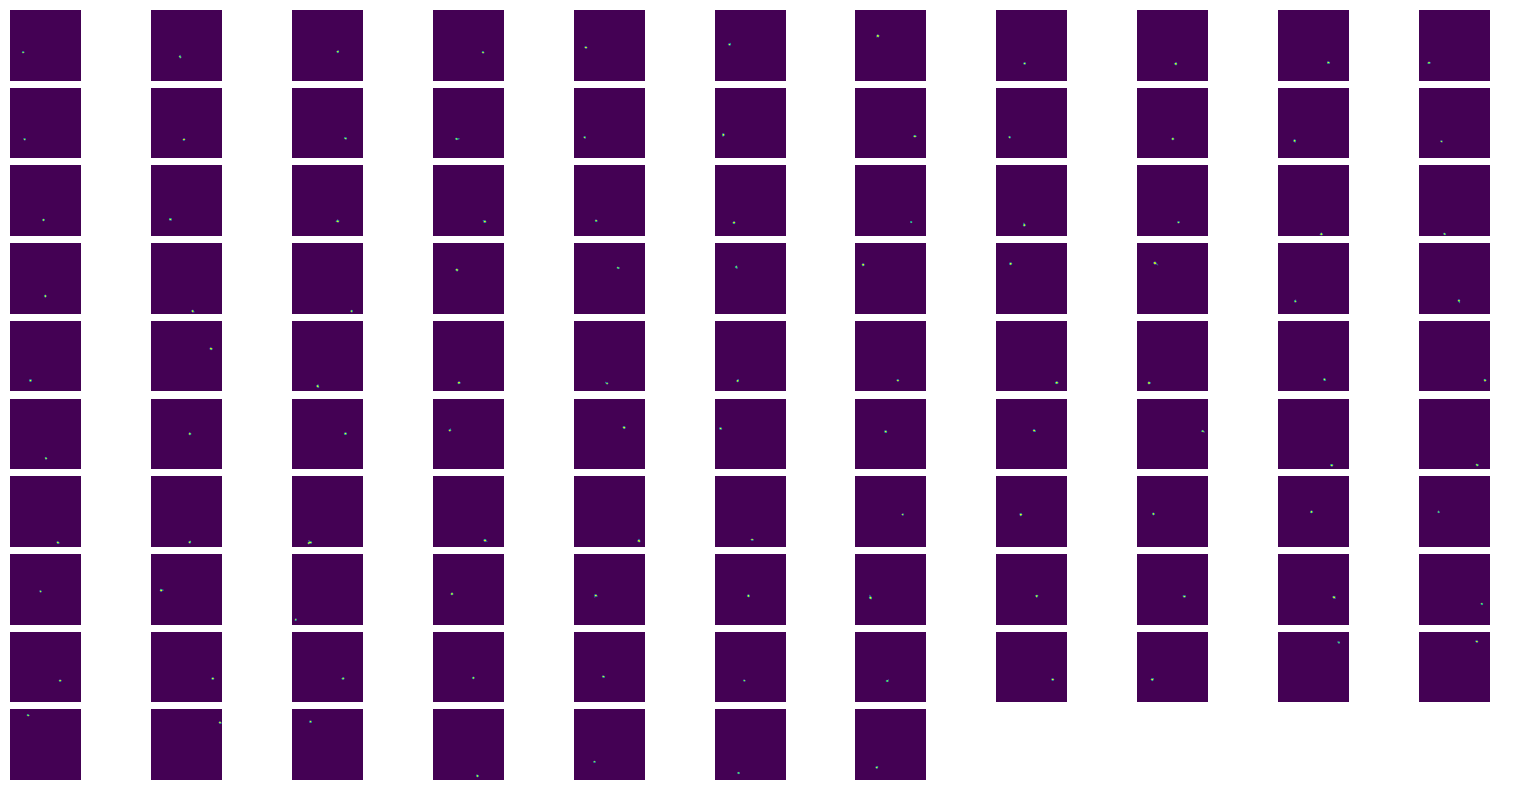

In [9]:
fig, axs = plt.subplots(10, 11, figsize=(20, 10))
plt.subplots_adjust(wspace=0, hspace=0.1)
for i, ax in enumerate(axs.flat):
    if i < 106:
        ax.imshow(data["roi_masks"][i, :, :])
    ax.axis("off")
plt.show()

## 1.4 Display the dF/F traces over time. <a class="anchor" id="displaydff"></a>
There are 106 different ROIs and to plot them nicely on top of each other we normalize them to the maximum value of the trace.

Text(0.09, 0.5, 'ROI #')

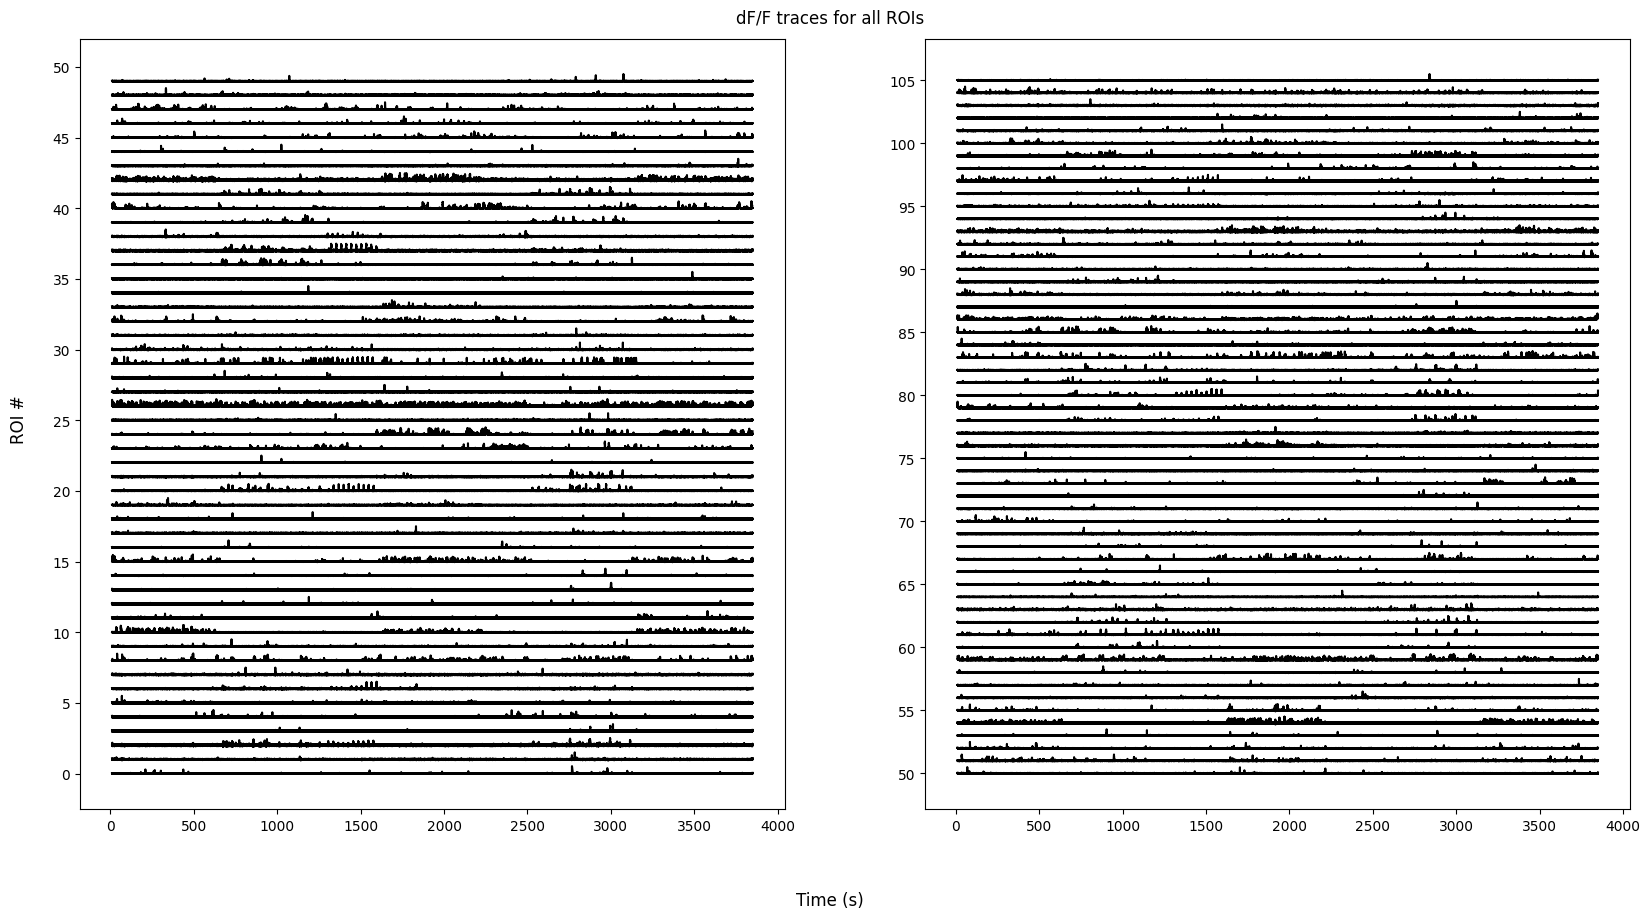

In [10]:
# plot dff traces into to subplots with the normalized dff values
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
for i in range(50):
    axs[0].plot(
        data["t"], (data["dff"][i, :] / np.max(data["dff"][i, :])) + i * 2, c="k"
    )
for i in range(50, 106):
    axs[1].plot(
        data["t"], (data["dff"][i, :] / np.max(data["dff"][i, :])) + i * 2, c="k"
    )
fig.supxlabel("Time (s)")
fig.supylabel("dF/F", x=0.09, y=0.5)

axs[0].set_yticks(np.arange(0, 101, 10))
axs[0].set_yticklabels(np.arange(0, 51, 5))
axs[1].set_yticks(np.arange(100, 212, 10))
axs[1].set_yticklabels(np.arange(50, 106, 5))
fig.suptitle(
    "dF/F traces for all ROIs",
    x=0.5,
    y=0.91,
)
fig.supylabel("ROI #", x=0.09, y=0.5)

## 1.5 Visualize the traces where the drifting gratings were shown. <a class="anchor" id="displaydffdrifting"></a>
For this we used the start and stop times in the stim_epoch_table. The added vertical lines indicate the start and stop times of the drifting gratings.

In [11]:
# get the start and end times of the drifting grating stimulus
stimulusOF = "drifting_gratings"
drifting_df = data["stim_epoch_table"]["stimulus"] == stimulusOF
start_times = data["stim_epoch_table"]["start"][drifting_df].to_numpy().astype(int)
end_times = data["stim_epoch_table"]["end"][drifting_df].to_numpy().astype(int)

print(
    f'Durations the stimulus of the drifting graitings: {data["t"][np.array(end_times)] - data["t"][np.array(start_times)]}'
)

Durations the stimulus of the drifting graitings: [599.50393 599.52014 683.60274]


Text(0.09, 0.5, 'dF/F')

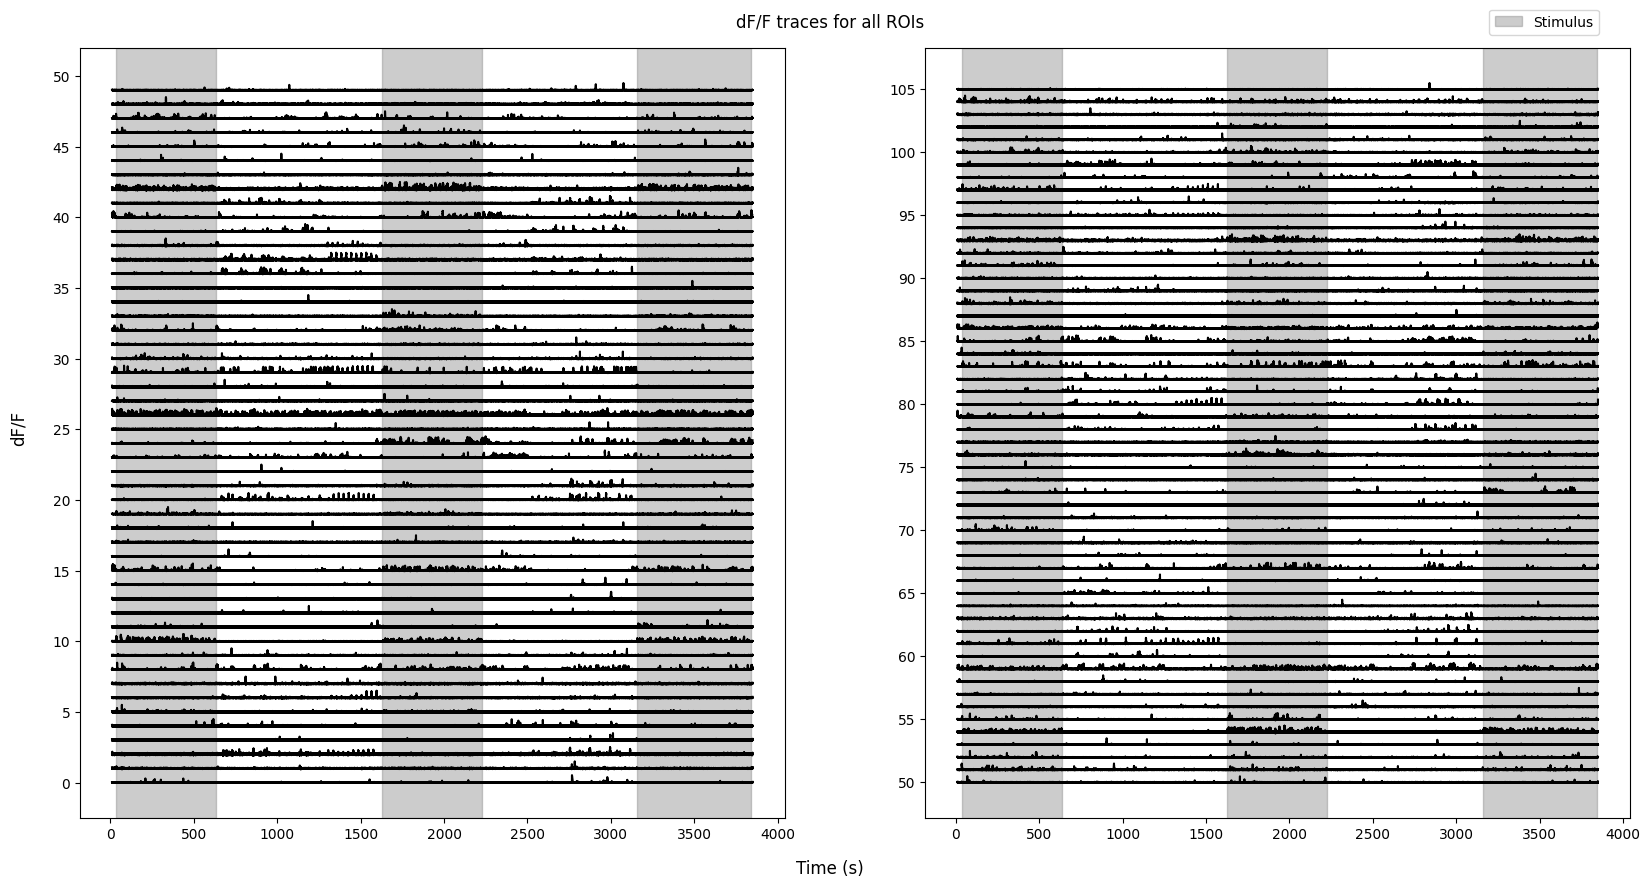

In [12]:
# ploting the dF/F traces for all ROIs with the stimulus times indicated in gray
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
for i in range(50):
    axs[0].plot(
        data["t"], (data["dff"][i, :] / np.max(data["dff"][i, :])) + i * 2, c="k"
    )
for i in range(50, 106):
    axs[1].plot(
        data["t"], (data["dff"][i, :] / np.max(data["dff"][i, :])) + i * 2, c="k"
    )
# plot the start and end times of the stimulus as gray areas
for i, s in enumerate(start_times):
    axs[0].axvspan(data["t"][s], data["t"][end_times[i]], alpha=0.4, color="gray")
    if i == 0:
        axs[1].axvspan(
            data["t"][s],
            data["t"][end_times[i]],
            alpha=0.4,
            color="gray",
            label="Stimulus",
        )
    else:
        axs[1].axvspan(data["t"][s], data["t"][end_times[i]], alpha=0.4, color="gray")

axs[0].set_yticks(np.arange(0, 101, 10))
axs[0].set_yticklabels(np.arange(0, 51, 5))
axs[1].set_yticks(np.arange(100, 212, 10))
axs[1].set_yticklabels(np.arange(50, 106, 5))
axs[1].legend(bbox_to_anchor=(0.8, 1.05), loc="upper left", borderaxespad=0.0)
fig.suptitle(
    "dF/F traces for all ROIs",
    x=0.5,
    y=0.915,
)
fig.supxlabel("Time (s)", x=0.5, y=0.05)
fig.supylabel("dF/F", x=0.09, y=0.5)

## 1.6 Visualize some active traces:
* 10, 29, 54, because they show high activity during the drifting gratings in all 3 trials
* 10 is selective to orientation 45° and 225°
* we can estimate that cell 29 is selective to orientation 270°?
* cell 54 is selectivwe to orientation to 135° and 315°? 

In [13]:
# define a nice color palette
colors_list = [
    "#271f7f",
    "#1565c0",
    "#009688",
    "#8bc34a",
    "#ffc107",
    "#ff9800",
    "#f44336",
    "#ad1457",
    "k",
]

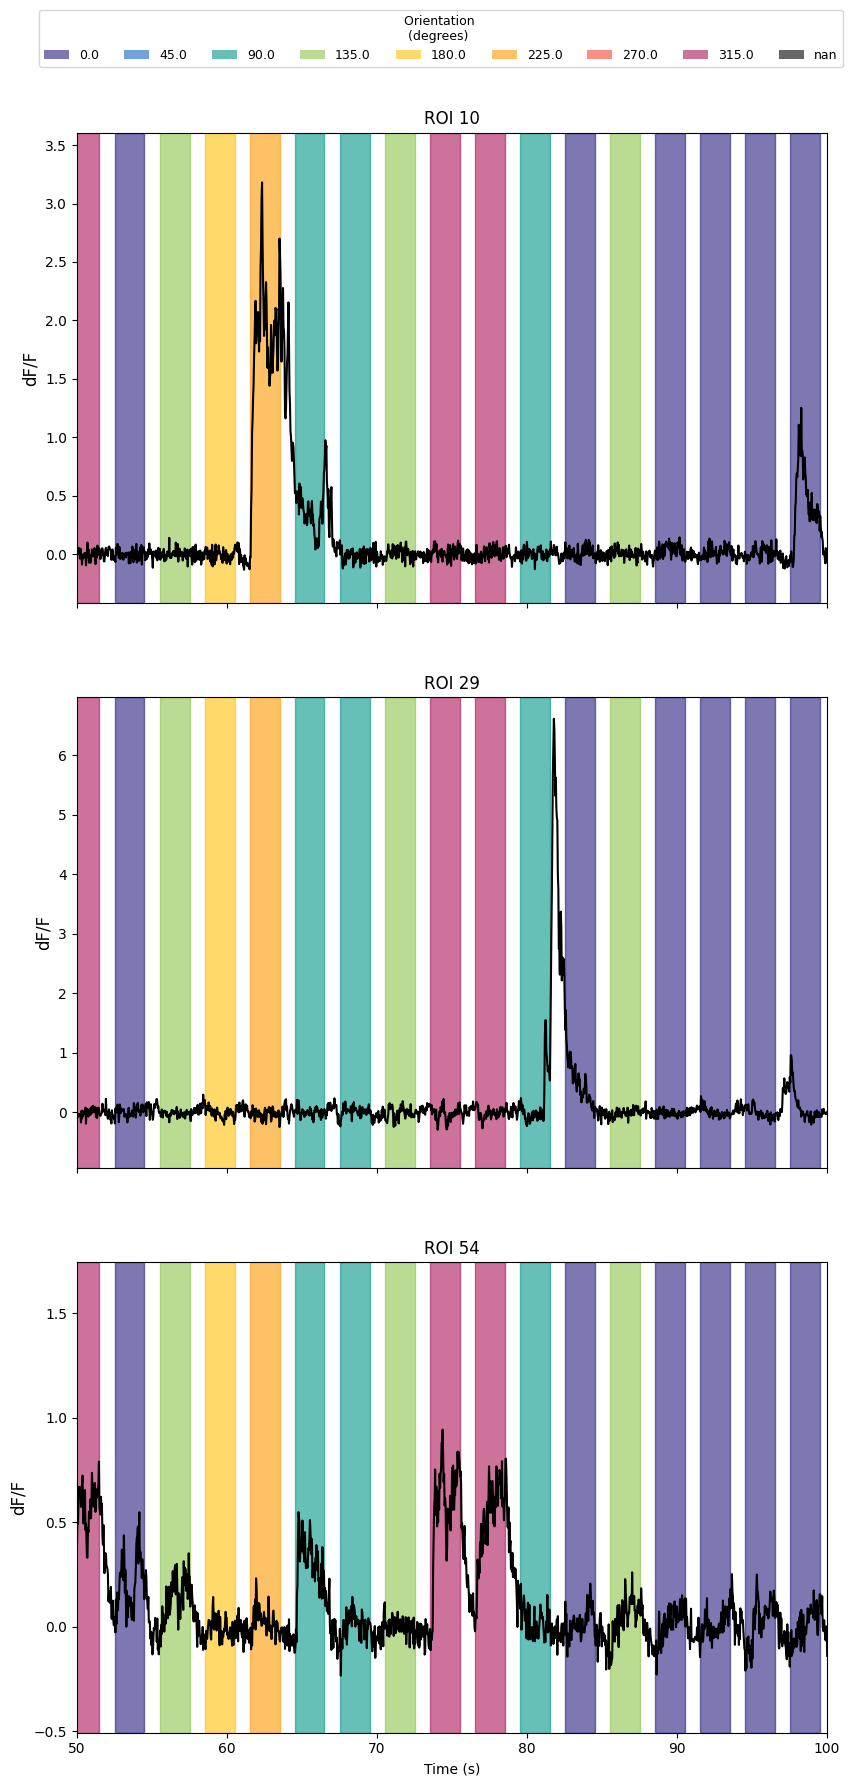

In [14]:
# define orientation and colors
orientations = np.sort(data["stim_table"]["orientation"].unique())
colors_orentation = np.zeros(len(data["stim_table"]["orientation"]), dtype=int)
for i, ori in enumerate(orientations):
    if i == 8:
        colors_orentation[data["stim_table"]["blank_sweep"] == 1] = i
    colors_orentation[data["stim_table"]["orientation"] == ori] = i

# define rois for the plot
rois = [
    10,
    29,
    54,
]

fig, axs = plt.subplots(len(rois), figsize=(10, 20), sharex=True)
plt.subplots_adjust(hspace=0.2, left=0.15, right=0.9, top=0.9, bottom=0.1)
# define xlim for the plot
limits = [50, 100]
for i, roi in enumerate(rois):
    axs[i].plot(data["t"], data["dff"][roi], c="k")
    for indx, (s, e) in enumerate(
        zip(
            data["t"][np.array(data["stim_table"]["start"], dtype=int)],
            data["t"][np.array(data["stim_table"]["end"], dtype=int)],
        )
    ):
        axs[i].axvspan(
            s,
            e,
            alpha=0.6,
            color=colors_list[colors_orentation[indx]],
        )
    orientation_patches = [
        mp.Rectangle(
            (0, 0),
            1,
            1,
            fc=colors_list[i],
            alpha=0.6,
            angle=orientations[i],
        )
        for i in range(9)
    ]

    axs[i].set_xlim(limits)
    axs[i].set_title(f"ROI {roi}")
    axs[i].set_ylabel("dF/F", fontsize=12)
axs[i].set_xlabel("Time (s)")


axs[0].legend(
    orientation_patches,
    orientations,
    bbox_to_anchor=(0.0, 1.2),
    loc="center left",
    borderaxespad=-3,
    fontsize=9,
    title="Orientation \n (degrees)",
    title_fontsize=9,
    ncol=9,
)

## Conclusion for data inspection:
1. The orientation is not equally distributed, and so are the 3 stimulus epochs.
2. We are setting the sampling rate for the project to 30 Hz. 
3. We can see some promissing cells for direction selectivity.
4. In ROI 29 we can see that the cell is spiking inbetween the trials, and we nee to handle this. 

# 2. Orientation selectivity in the DF/F traces <a class="anchor" id="orientation_selectivity"></a>

## 2.1 Polar plot of one ROI

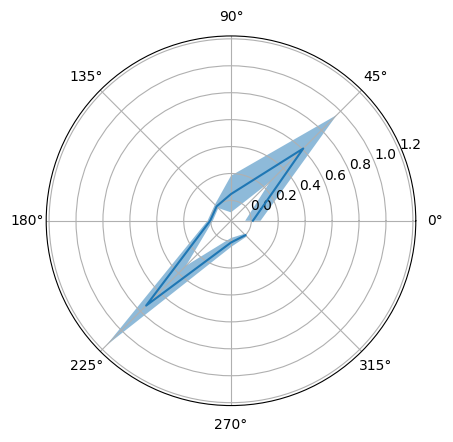

In [15]:
# caluclate the mean and std of the calcium response for each orientation for each roi
# see utils_project1.py for the functions dff_orientation

mean_calcium_orientation, std_calcium_orientation = utils.dff_orientation(data)

# define the ROI for the plot
roi = 10
# plot a polar plot for for each orientation
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": "polar"})

ax.plot(
    np.deg2rad(
        np.sort(
            data["stim_table"]["orientation"].unique()[
                ~np.isnan(data["stim_table"]["orientation"].unique())
            ]
        )
    ),
    mean_calcium_orientation[roi, :],
)
ax.fill_between(
    np.deg2rad(
        np.sort(
            data["stim_table"]["orientation"].unique()[
                ~np.isnan(data["stim_table"]["orientation"].unique())
            ]
        )
    ),
    mean_calcium_orientation[roi, :] - std_calcium_orientation[roi, :],
    mean_calcium_orientation[roi, :] + std_calcium_orientation[roi, :],
    alpha=0.5,
)

## 2.2 How does the temporal resolution interfering with the orientation selectivity?

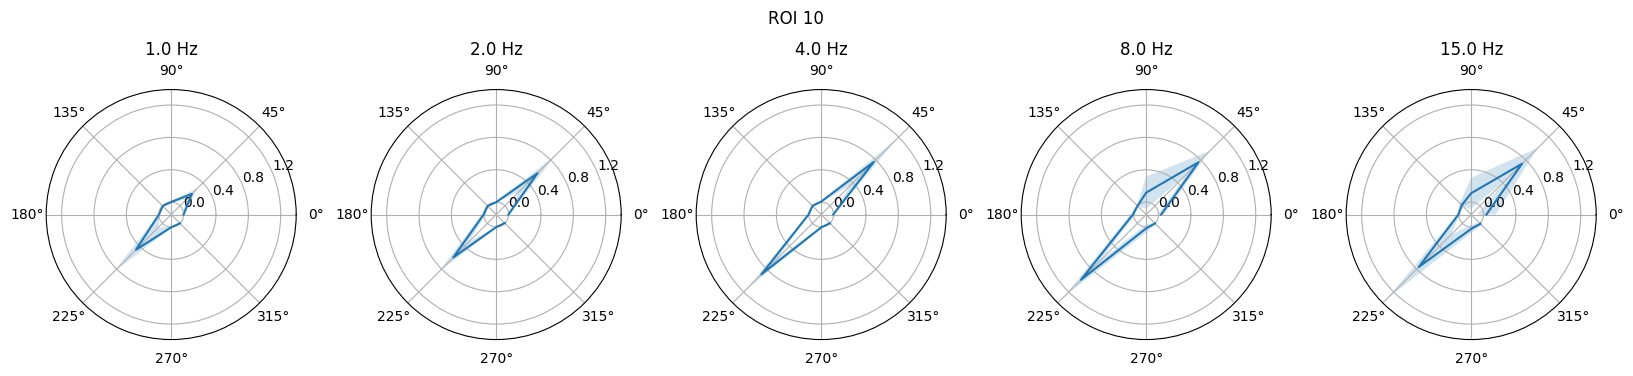

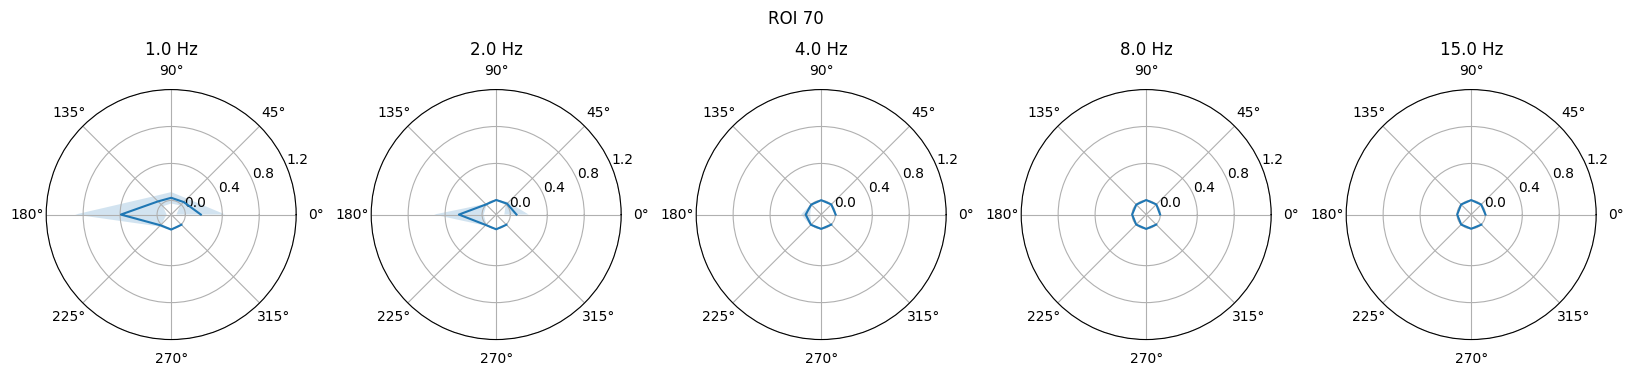

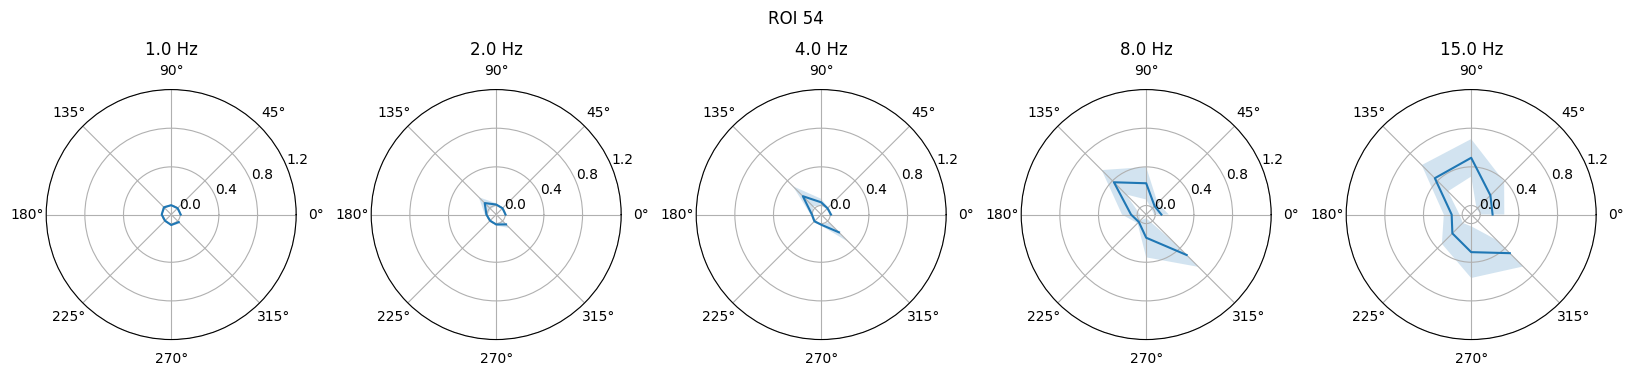

In [16]:
(
    mean_calcium_orientation_temp,
    std_calcium_orientation_temp,
) = utils.dff_orientation_temporal_frequency(data)
temporal_frequencies = data["stim_table"]["temporal_frequency"].unique()
temporal_frequencies = np.sort(temporal_frequencies[~np.isnan(temporal_frequencies)])

# selct a roi
rois = [10, 70, 54]
for roi in rois:
    # plot a polar plot for for each orientation and temporal frequency
    fig, axs = plt.subplots(
        1, 5, subplot_kw={"projection": "polar"}, figsize=(20, 10), sharey=True
    )
    plt.subplots_adjust(wspace=0.3)
    for i, ax in enumerate(axs.flat):
        ax.plot(
            np.deg2rad(
                np.sort(
                    data["stim_table"]["orientation"].unique()[
                        ~np.isnan(data["stim_table"]["orientation"].unique())
                    ]
                )
            ),
            mean_calcium_orientation_temp[roi, :, i],
        )
        # add std to the plot
        ax.fill_between(
            np.deg2rad(
                np.sort(
                    data["stim_table"]["orientation"].unique()[
                        ~np.isnan(data["stim_table"]["orientation"].unique())
                    ]
                )
            ),
            mean_calcium_orientation_temp[roi, :, i]
            - std_calcium_orientation_temp[roi, :, i],
            mean_calcium_orientation_temp[roi, :, i]
            + std_calcium_orientation_temp[roi, :, i],
            alpha=0.2,
        )
        ax.set_title(f"{temporal_frequencies[i]} Hz")
        ax.set_yticks(np.arange(0, 1.5, 0.4))
        fig.suptitle(f"ROI {roi}", y=0.70)

### How is the temporal frequency interfering with the orientation selectivity?
* ##### We can see in ROI 10 that with an increase of the temporal frequency the orientation selectivity is increasing as well.
* ##### Whereas in ROI 70 the orientation selectivity is decreasing with an increase of the temporal frequency.


# 3. Transforming the calcium traces to spikes
* only transform the traces where the drifting gratings were shown
* use the algorithm from coding lab 3, py-oopsi

In [17]:
# check if spike data is already saved
data_path = Path("../data")

# create the data path if it does not exist
data_path.mkdir(exist_ok=True)
# load the data
if Path(data_path / "spike_data.npy").exists():
    spike_data = np.load("../data/spike_data.npy")
else:
    spike_data = np.zeros((data["dff"].shape[0], data["dff"].shape[1]))
    for roi in range(data["dff"].shape[0]):
        # initialize the paraparameters for the oopsi algorithm
        F, P = ops.oopsi_init_par(data["dff"][roi], 1 / 30)
        n, C, post = ops.oopsi_est_map(F, P)
        print(n.shape)
        print(roi)
        spike_data[roi] = n
    np.save("../data/spike_data.npy", spike_data)

## 3.1 Spike data was thresholded
* ##### Spike data from oopsi algorithm was between 0 and 1 and to get, so this is the probability of the spike occuring at that time.
* ##### We set a threshold at 0.2 through visual assessment! 

In [18]:
# thershold the spike data at get the time points where the spike occurs
threshold = 0.2
spike_data[spike_data < threshold] = 0
spike_data[spike_data >= threshold] = 1
spike_data = spike_data.astype(int)
# get the spike times for each ROI
spike_times = []
for roi in range(spike_data.shape[0]):
    spike_times.append(data["t"][spike_data[roi, :] >= 0.5])
spike_times = np.array(spike_times, dtype=object)

## 3.2 Plotting the Spike data with DF/F

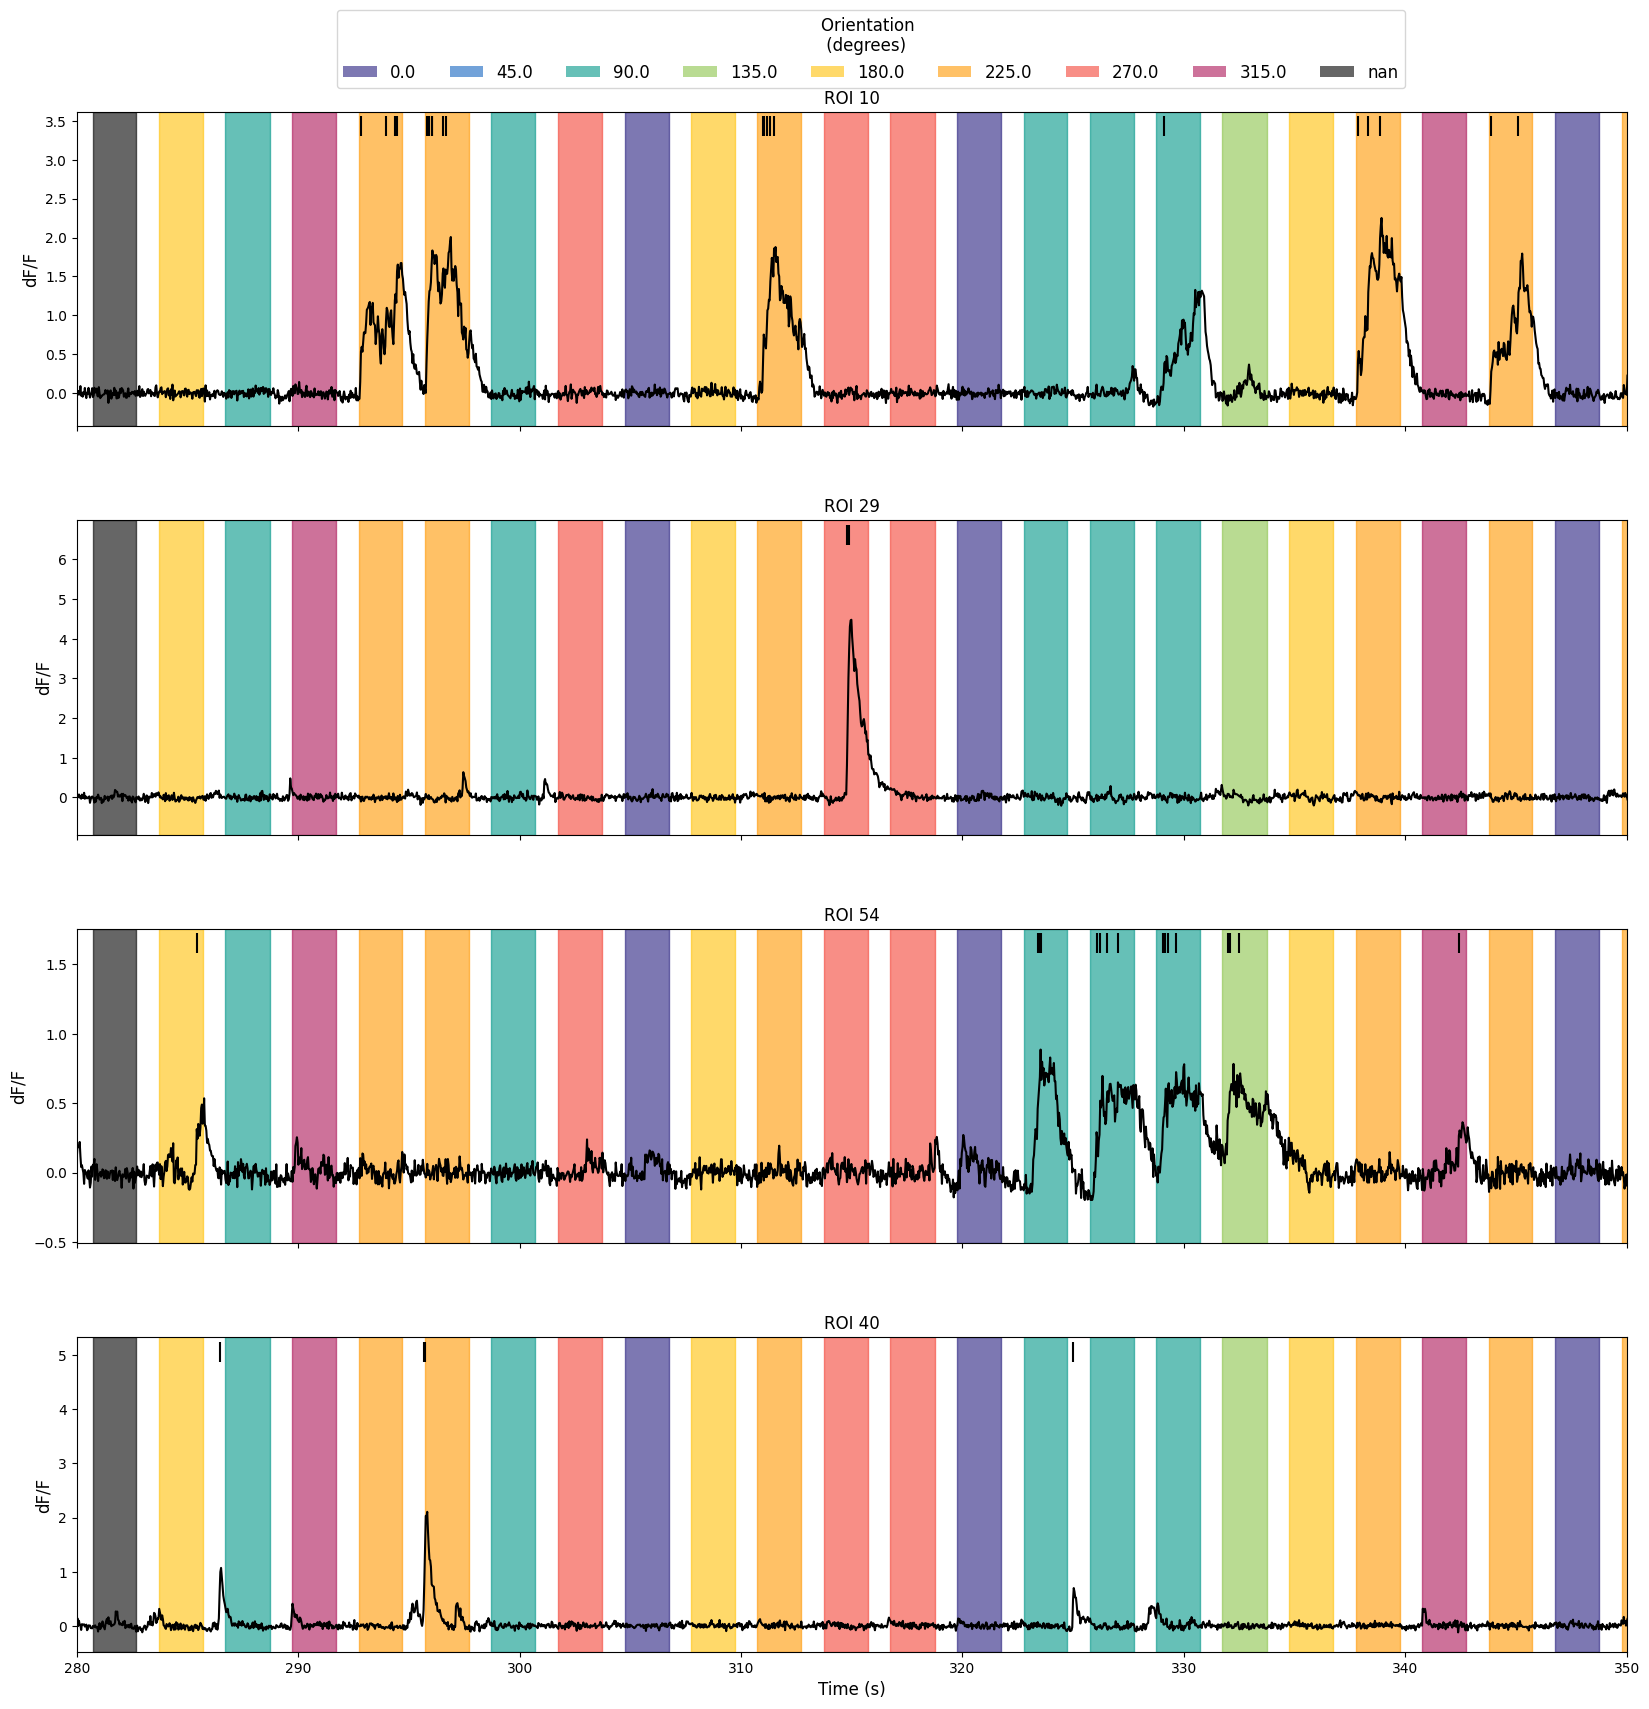

In [19]:
orientations = np.sort(data["stim_table"]["orientation"].unique())
colors_orentation = np.zeros(len(data["stim_table"]["orientation"]), dtype=int)
for i, ori in enumerate(orientations):
    if i == 8:
        colors_orentation[data["stim_table"]["blank_sweep"] == 1] = i
    colors_orentation[data["stim_table"]["orientation"] == ori] = i

rois = [10, 29, 54, 40]

fig, axs = plt.subplots(len(rois), figsize=(20, 20), sharex=True)
plt.subplots_adjust(hspace=0.3)

limits = [280, 350]
for i, roi in enumerate(rois):
    axs[i].plot(data["t"], data["dff"][roi], c="k")
    axs[i].scatter(
        spike_times[roi],
        np.ones(len(spike_times[roi])) * np.max(data["dff"][roi]) + 0.01,
        c="k",
        marker="|",
        s=200,
        zorder=10,
    )
    for indx, (s, e) in enumerate(
        zip(
            data["t"][np.array(data["stim_table"]["start"], dtype=int)],
            data["t"][np.array(data["stim_table"]["end"], dtype=int)],
        )
    ):
        axs[i].axvspan(
            s,
            e,
            alpha=0.6,
            color=colors_list[colors_orentation[indx]],
        )
    orientation_patches = [
        mp.Rectangle(
            (0, 0),
            1,
            1,
            fc=colors_list[i],
            alpha=0.6,
            angle=orientations[i],
        )
        for i in range(9)
    ]

    axs[i].set_xlim(limits)
    axs[i].set_title(f"ROI {roi}")
    axs[i].set_ylabel("dF/F", fontsize=12)
axs[i].set_xlabel("Time (s)", fontsize=12)


axs[0].legend(
    orientation_patches,
    orientations,
    bbox_to_anchor=(0.2, 1.2),
    loc="center left",
    borderaxespad=-3,
    fontsize=12,
    title="Orientation \n (degrees)",
    title_fontsize=12,
    ncol=9,
)

In [20]:
# mean calcium value for each orientation
# get the spike times for each orientation
orientations = data["stim_table"]["orientation"].unique()
orientations = orientations[~np.isnan(orientations)]
mean_spike_orientation = np.zeros((data["dff"].shape[0], len(orientations)))
std_spike_orientation = np.zeros((data["dff"].shape[0], len(orientations)))

for i, orientation in enumerate(np.sort(orientations)):
    start_times = (
        data["stim_table"]["start"][data["stim_table"]["orientation"] == orientation]
        .to_numpy()
        .astype(int)
    )
    end_times = (
        data["stim_table"]["end"][data["stim_table"]["orientation"] == orientation]
        .to_numpy()
        .astype(int)
    )
    for roi in range(data["dff"].shape[0]):
        mean_spike_orientation[roi, i] = np.mean(
            [np.sum(spike_data[roi][s:e]) for s, e in zip(start_times, end_times)],
            axis=0,
        )
        std_spike_orientation[roi, i] = np.std(
            [np.sum(spike_data[roi][s:e]) for s, e in zip(start_times, end_times)],
            axis=0,
        )

Text(0.5, 1.0, 'ROI 10')

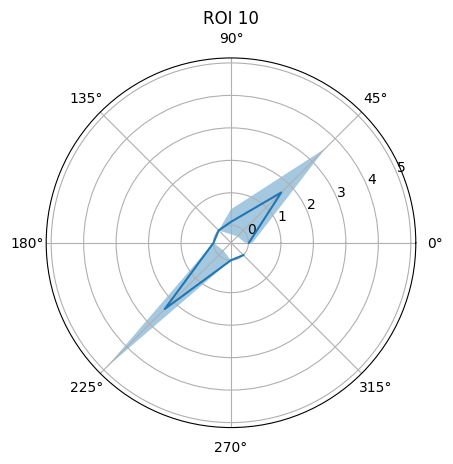

In [21]:
# plot a polar plot for for each orientation
roi = 10
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": "polar"})
ax.plot(
    np.deg2rad(
        np.sort(
            data["stim_table"]["orientation"].unique()[
                ~np.isnan(data["stim_table"]["orientation"].unique())
            ]
        )
    ),
    mean_spike_orientation[roi, :],
)
# add std to the plot
ax.fill_between(
    np.deg2rad(
        np.sort(
            data["stim_table"]["orientation"].unique()[
                ~np.isnan(data["stim_table"]["orientation"].unique())
            ]
        )
    ),
    mean_spike_orientation[roi, :] - std_spike_orientation[roi, :],
    mean_spike_orientation[roi, :] + std_spike_orientation[roi, :],
    alpha=0.4,
)
ax.set_title(f"ROI {roi}")

In [22]:
# mean calcium value for each orientation
orientations = data["stim_table"]["orientation"].unique()
orientations = np.sort(orientations[~np.isnan(orientations)])
temporal_frequencies = data["stim_table"]["temporal_frequency"].unique()
temporal_frequencies = np.sort(temporal_frequencies[~np.isnan(temporal_frequencies)])

mean_spike_orientation_freq = np.zeros(
    (data["dff"].shape[0], len(orientations), len(temporal_frequencies))
)
std_spike_orientation_freq = np.zeros(
    (data["dff"].shape[0], len(orientations), len(temporal_frequencies))
)
for i, orientation in enumerate(orientations):
    for j, freq in enumerate(temporal_frequencies):
        start_times = (
            data["stim_table"]["start"][
                (data["stim_table"]["orientation"] == orientation)
                & (data["stim_table"]["temporal_frequency"] == freq)
            ]
            .to_numpy()
            .astype(int)
        )
        end_times = (
            data["stim_table"]["end"][
                (data["stim_table"]["orientation"] == orientation)
                & (data["stim_table"]["temporal_frequency"] == freq)
            ]
            .to_numpy()
            .astype(int)
        )
        for roi in range(data["dff"].shape[0]):
            mean_spike_orientation_freq[roi, i, j] = np.mean(
                [np.sum(spike_data[roi][s:e]) for s, e in zip(start_times, end_times)],
                axis=0,
            )
            std_spike_orientation_freq[roi, i, j] = np.std(
                [np.sum(spike_data[roi][s:e]) for s, e in zip(start_times, end_times)],
                axis=0,
            )

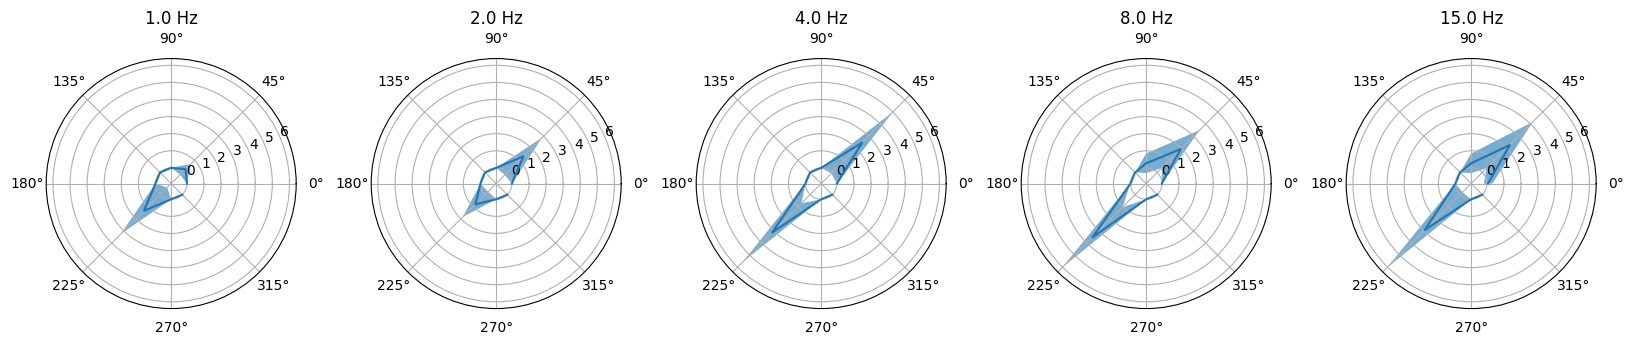

In [23]:
fig, axs = plt.subplots(
    1, 5, subplot_kw={"projection": "polar"}, figsize=(20, 10), sharey=True
)
roi = 10
plt.subplots_adjust(wspace=0.3)
for i, ax in enumerate(axs.flat):
    ax.plot(
        np.deg2rad(
            np.sort(
                data["stim_table"]["orientation"].unique()[
                    ~np.isnan(data["stim_table"]["orientation"].unique())
                ]
            )
        ),
        mean_spike_orientation_freq[roi, :, i],
    )
    # add std to the plot
    ax.fill_between(
        np.deg2rad(
            np.sort(
                data["stim_table"]["orientation"].unique()[
                    ~np.isnan(data["stim_table"]["orientation"].unique())
                ]
            )
        ),
        mean_spike_orientation_freq[roi, :, i] - std_spike_orientation_freq[roi, :, i],
        mean_spike_orientation_freq[roi, :, i] + std_spike_orientation_freq[roi, :, i],
        alpha=0.6,
    )
    ax.set_title(f"{temporal_frequencies[i]} Hz")

# 4. Choosing direction selective cells with permutation test
* ##### We excluded ROIs with no activity at all
* ##### We excluded ROIs with activity outside the stimulus presentation 
* ##### We only chose ROIs that had 75 percent of the activity in the stimulus presentation, because at 50 percent we can't be sure if the ROI is reacting to the stimulus.
* ##### For a ROI to be orientation selective it has to have at least in 5 trials one Spike for one orientation. This was necessary because otherwise we would have had a lot of false positives in the permutation testing 

## 4.1 Applying restrictions / qualifications to the data

In [24]:
# orientation selctivity to rois that have at leat 5 trials where the neuron fired for one orientation
# calculate the p value for each roi
p_dirs = np.ones(data["dff"].shape[0], dtype=float)

rois_qualify = np.sum(spike_data, axis=1) > 0
qualifying_rois = np.where(rois_qualify)[0]

for roi in qualifying_rois:
    dirs, counts = utils.get_spike_counts_per_orientation(data, spike_data, roi)
    counts_direction_unique = [
        len(np.where(counts[dirs == d] > 0)[0]) for d in np.unique(dirs)
    ]
    empty_check = np.array(counts_direction_unique) >= 5
    if np.sum(empty_check) > 0:
        p_dirs[roi] = utils.testTuning(counts, dirs, psi=1, niters=1000, show=False)[0]
    else:
        p_dirs[roi] = 1.0
rois_active = np.where(p_dirs < 0.01)[0]
print("Preliminary number of ROIs that are orientation selective: ", len(rois_active))

Preliminary number of ROIs that are orientation selective:  21


In [25]:
# Calculating the spike counts for each ROI inbetween the stimulus
counts_inbetween = np.zeros(data["dff"].shape[0], dtype=object)
start_times_inbetween = data["stim_table"]["end"].to_numpy().astype(int)
end_times_inbetween = data["stim_table"]["start"].to_numpy().astype(int)[1:]

for roi in range(data["dff"].shape[0]):
    idx_spikes = np.where(spike_data[roi] == 1)[0]
    counts_inbetween_roi = []
    for i, (s, e) in enumerate(zip(start_times_inbetween, end_times_inbetween)):
        ori = data["stim_table"]["orientation"][i]
        if np.isnan(ori):
            continue
        counts_inbetween_roi.append(np.sum((idx_spikes >= s) & (idx_spikes <= e)))
    counts_inbetween[roi] = np.sum(np.array(counts_inbetween_roi))

In [26]:
# Exclude rois that have less than 75% of their spikes in the stimulus
print(len(rois_active))
qualifying_rois_snr = []
for roi in rois_active:
    dirs, counts_stim = utils.get_spike_counts_per_orientation(data, spike_data, roi)
    counts_inb = counts_inbetween[roi]
    # check if 75% of the total spikes are in the stimulus
    if np.sum(counts_stim) / (counts_inb + np.sum(counts_stim)) >= 0.75:
        qualifying_rois_snr.append(roi)
print(f"These ROIs qualify for further analysis: {qualifying_rois_snr}")
print(f"Number of ROIs that qualify: {len(qualifying_rois_snr)}")

21
These ROIs qualify for further analysis: [10, 19, 33, 42, 51, 54, 55, 70, 84, 91, 102]
Number of ROIs that qualify: 11


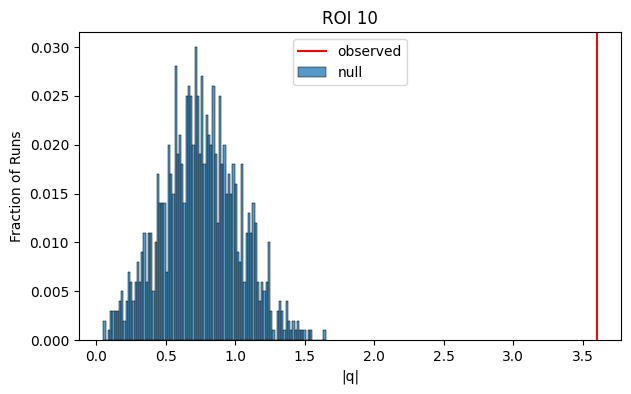

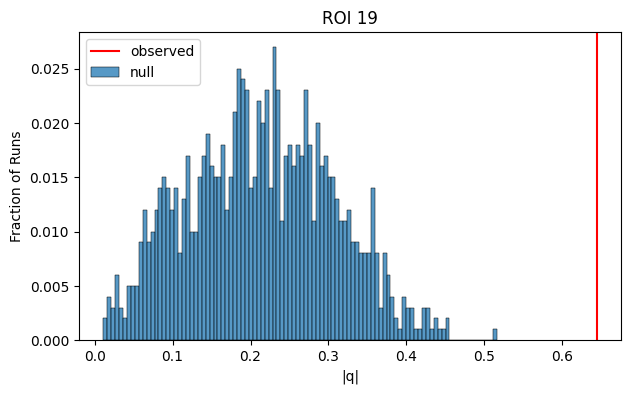

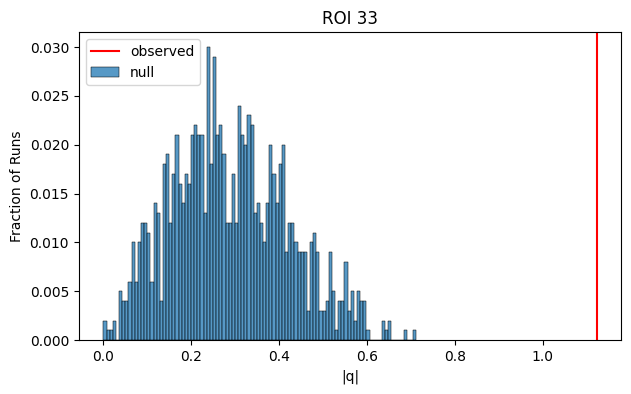

In [27]:
# show the permutation test for the first 3 orientation selective ROIs
rois = qualifying_rois_snr

for roi in rois[:3]:
    dirs, counts = utils.get_spike_counts_per_orientation(data, spike_data, roi)
    utils.testTuning(
        counts, dirs, psi=1, niters=1000, show=True, title_name=f"ROI {roi}"
    )

## 4.2 Plotting the orientation selective ROIs 

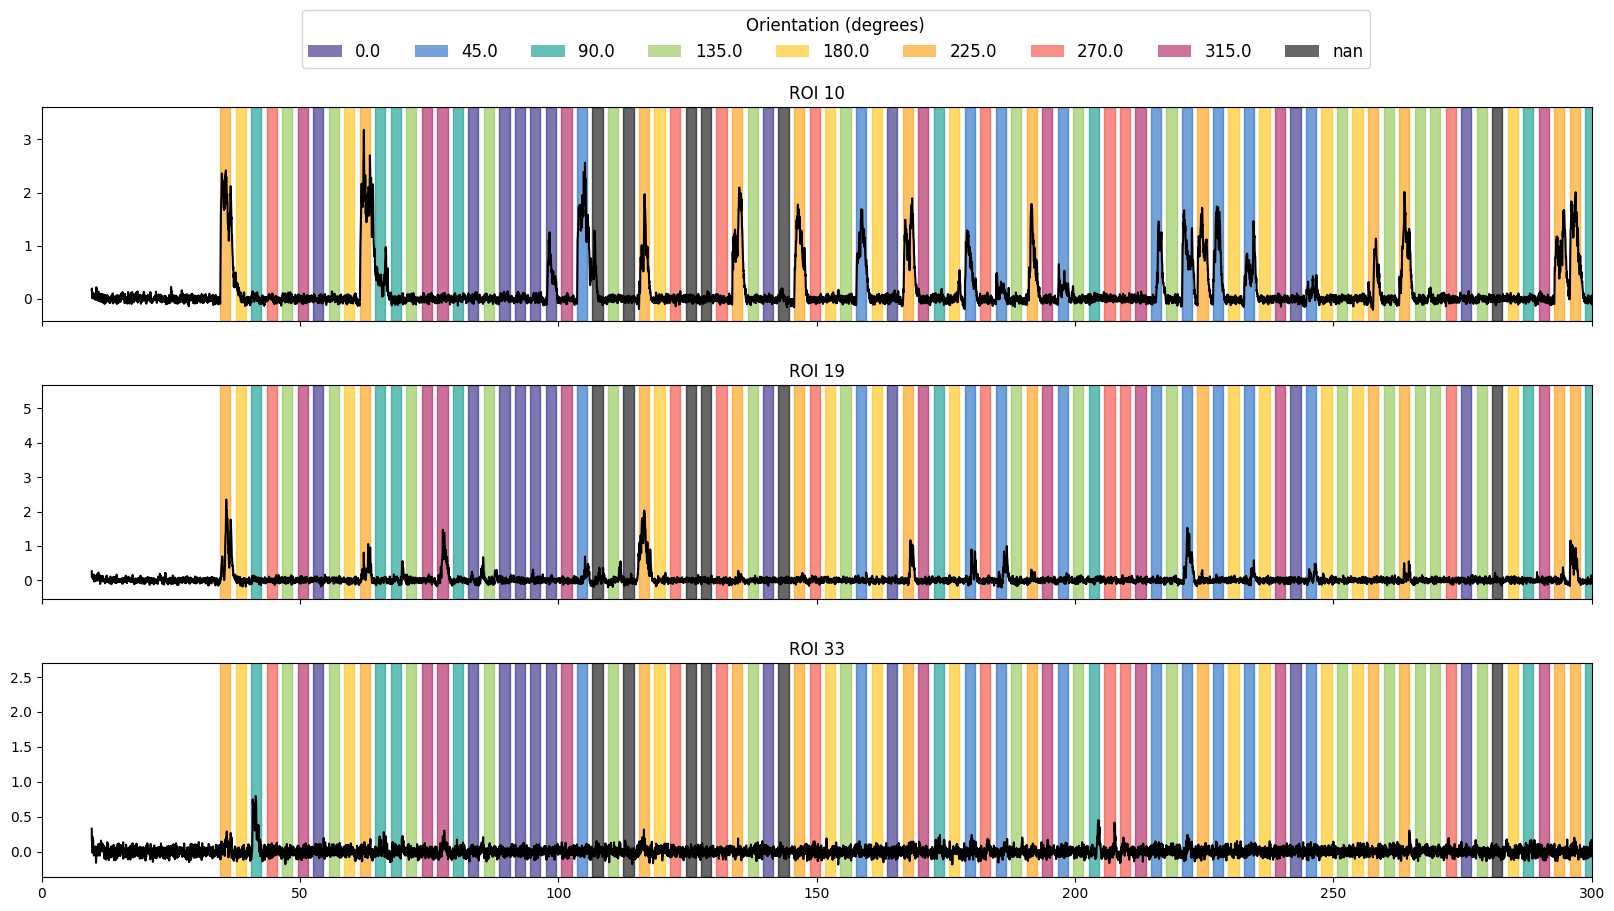

In [28]:
orientations = np.sort(data["stim_table"]["orientation"].unique())
colors_orentation = np.zeros(len(data["stim_table"]["orientation"]), dtype=int)
for i, ori in enumerate(orientations):
    if i == 8:
        colors_orentation[data["stim_table"]["blank_sweep"] == 1] = i
    colors_orentation[data["stim_table"]["orientation"] == ori] = i

rois_plotting = 3

fig, axs = plt.subplots(len(rois[:rois_plotting]), figsize=(20, 10), sharex=True)
plt.subplots_adjust(hspace=0.3)
limits = [0, 300]
for i, roi in enumerate(rois[:rois_plotting]):
    axs[i].plot(data["t"], data["dff"][roi], c="k")
    for indx, (s, e) in enumerate(
        zip(
            data["t"][np.array(data["stim_table"]["start"], dtype=int)],
            data["t"][np.array(data["stim_table"]["end"], dtype=int)],
        )
    ):
        axs[i].axvspan(
            s,
            e,
            alpha=0.6,
            color=colors_list[colors_orentation[indx]],
        )
    orientation_patches = [
        mp.Rectangle(
            (0, 0),
            1,
            1,
            fc=colors_list[i],
            alpha=0.6,
            angle=orientations[i],
        )
        for i in range(9)
    ]

    axs[i].set_xlim(limits)
    axs[i].set_title(f"ROI {roi}")


axs[0].legend(
    orientation_patches,
    orientations,
    bbox_to_anchor=(0.2, 1.32),
    loc="center left",
    borderaxespad=-3,
    fontsize=12,
    title="Orientation (degrees)",
    title_fontsize=12,
    ncol=9,
)

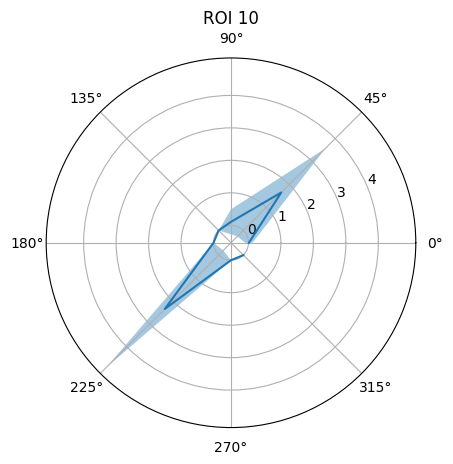

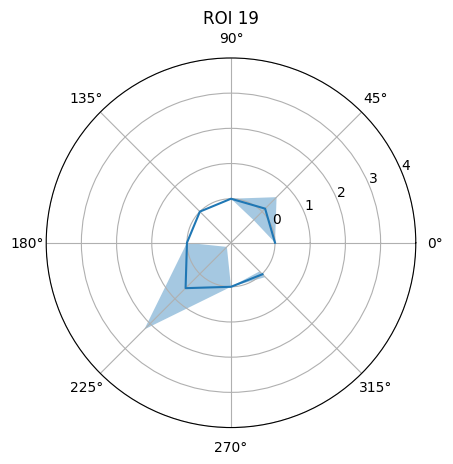

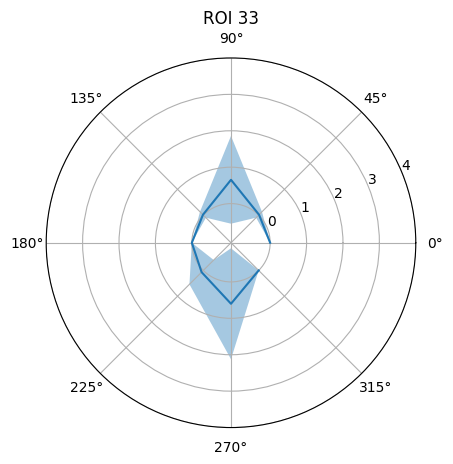

In [29]:
# plot a polar plot for for each orientation
for roi in rois[:rois_plotting]:
    fig, ax = plt.subplots(1, 1, subplot_kw={"projection": "polar"})
    ax.plot(
        np.deg2rad(
            np.sort(
                data["stim_table"]["orientation"].unique()[
                    ~np.isnan(data["stim_table"]["orientation"].unique())
                ]
            )
        ),
        mean_spike_orientation[roi, :],
    )
    # add std to the plot
    ax.fill_between(
        np.deg2rad(
            np.sort(
                data["stim_table"]["orientation"].unique()[
                    ~np.isnan(data["stim_table"]["orientation"].unique())
                ]
            )
        ),
        mean_spike_orientation[roi, :] - std_spike_orientation[roi, :],
        mean_spike_orientation[roi, :] + std_spike_orientation[roi, :],
        alpha=0.4,
    )
    ax.set_yticks(np.arange(0, 5, 1))
    ax.set_title(f"ROI {roi}")

In [30]:
orientations = data["stim_table"]["orientation"].unique()
orientations = np.sort(orientations[~np.isnan(orientations)])
SpikeTable_df = pd.DataFrame(columns=rois)
instant_firing_rate_df = pd.DataFrame(columns=rois, index=orientations)

prestim = 15  # index
poststim = 15
time_window = prestim + poststim + 59

for j, l in enumerate(rois):
    SpikeTable = np.zeros((len(data["stim_table"]["start"]), time_window))
    for i in range(len(data["stim_table"]["start"])):
        starts = data["stim_table"]["start"][i]
        ends = data["stim_table"]["end"][i]
        # not the exact same length for each trial
        if len(spike_data[l][int(starts) - prestim : int(ends) + poststim]) >= 90:
            difference = (
                len(spike_data[l][int(starts) - prestim : int(ends) + poststim])
                - time_window,
            )[0]
            SpikeTable[i, :] = spike_data[l][
                int(starts) - prestim : int(ends) + poststim - difference
            ]
        else:
            SpikeTable[i, :] = spike_data[l][
                int(starts) - prestim : int(ends) + poststim
            ]
    SpikeTable = np.array(SpikeTable, dtype=object)
    SpikeTable_df[l] = [SpikeTable]
    for m, orientation in enumerate(orientations):
        instant_firing_rate_df[l][m] = (
            np.nanmean(
                SpikeTable_df[l][0][
                    data["stim_table"]["orientation"] == orientation, :
                ],
                axis=0,
            )
            * 30
        )


print(instant_firing_rate_df.shape)


# smooth function for the spike data
def smooth_rate(instant_firing_rate, window):
    smoothed_rate = np.empty((len(instant_firing_rate), len(instant_firing_rate[0])))
    smoothed_rate.fill(np.nan)
    step_size = int(np.floor(window / 2))
    length = np.arange(
        (window - step_size), len(instant_firing_rate[0]) - step_size + 1
    )
    orientations = data["stim_table"]["orientation"].unique()
    orientations = np.sort(orientations[~np.isnan(orientations)])

    for i in range(len(instant_firing_rate)):
        # print(f"i = {i}")
        for j in range(len(length)):
            # print(f"j = {j}")
            smoothed_rate[i, j] = np.nanmean(
                instant_firing_rate[orientations[i]][(j - step_size) : (j + step_size)]
            )
    return smoothed_rate


# smooth sorted_instant_firing_rate_cell10
smoothed_firing_rates = smooth_rate(instant_firing_rate_df[10], 7)

(8, 11)


/var/folders/6f/4s63gb612m185fbsprljhfmh0000gn/T/ipykernel_79930/2116434509.py:31: FutureWarning: Treating integers as positional in Series.__setitem__ with a Float64Index is deprecated. In a future version, `series[an_int] = val` will insert a new key into the Series. Use `series.iloc[an_int] = val` to treat the key as positional.
  instant_firing_rate_df[l][m] = (
/var/folders/6f/4s63gb612m185fbsprljhfmh0000gn/T/ipykernel_79930/2116434509.py:60: RuntimeWarning: Mean of empty slice
  smoothed_rate[i, j] = np.nanmean(


[Text(0, 0, '0.0'),
 Text(1, 0, '45.0'),
 Text(2, 0, '90.0'),
 Text(3, 0, '135.0'),
 Text(4, 0, '180.0'),
 Text(5, 0, '225.0'),
 Text(6, 0, '270.0'),
 Text(7, 0, '315.0')]

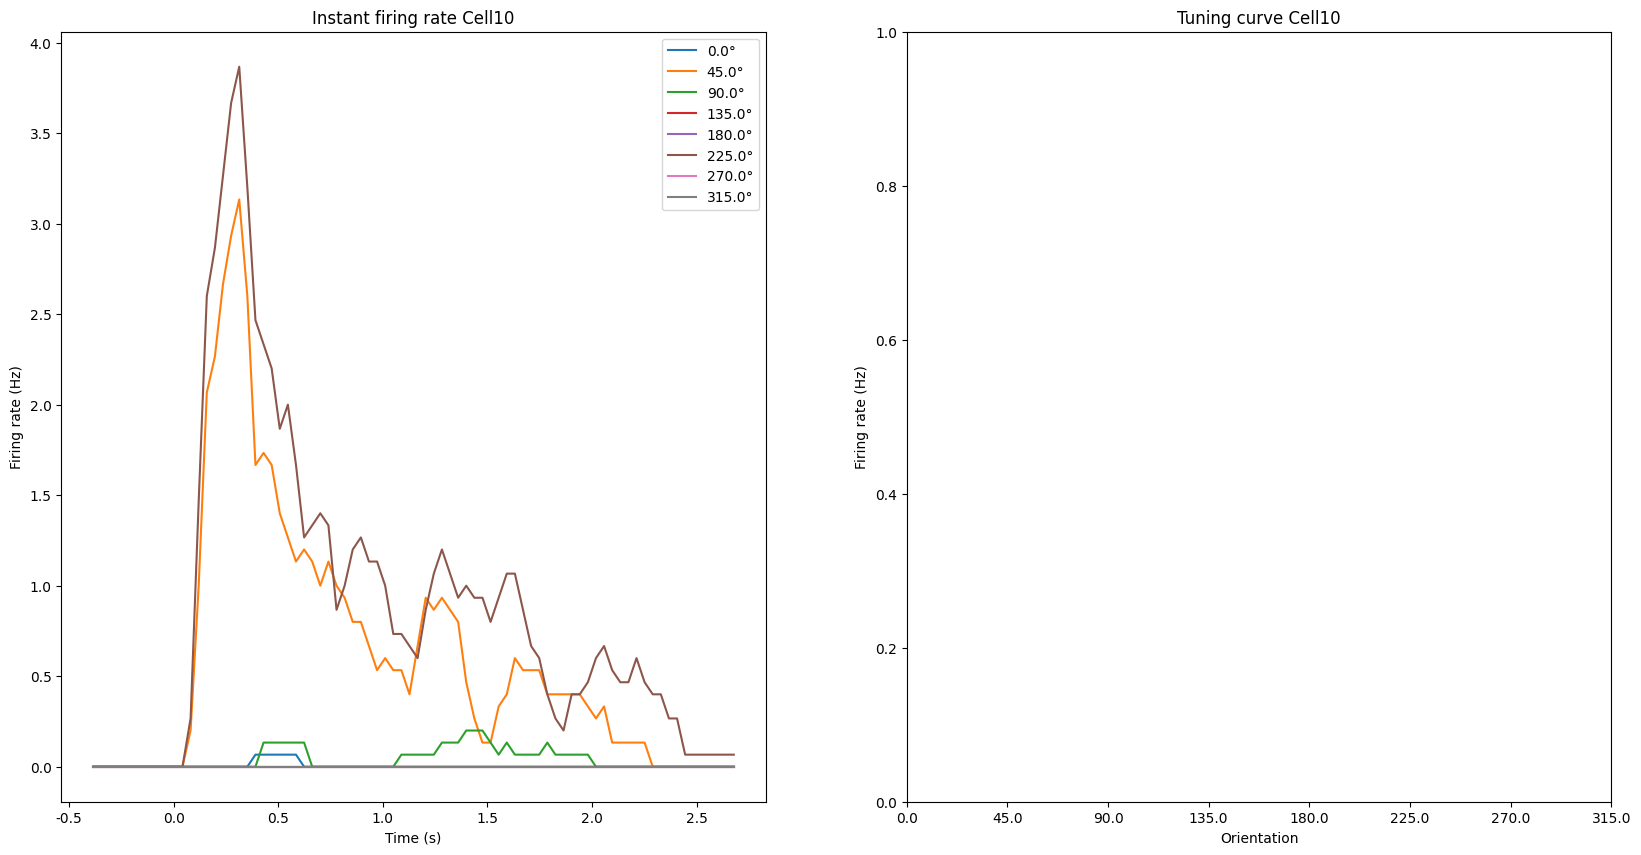

In [31]:
# plot instant rates and tuning curve in one plot
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
for i in range(len(orientations)):
    axs[0].plot(
        np.arange(len(smoothed_firing_rates[0])) / 30,
        smoothed_firing_rates[i],
        label=f"{orientations[i]}°",
    )
axs[0].set_title("Instant firing rate Cell10")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Firing rate (Hz)")
axs[0].set_xticks(np.arange(0, 90, 12.9) / 30)
axs[0].set_xticklabels(np.arange(-0.5, 3, 0.5))
axs[0].legend()
axs[1].set_title("Tuning curve Cell10")
axs[1].set_xlabel("Orientation")
axs[1].set_ylabel("Firing rate (Hz)")
axs[1].set_xticks(np.arange(0, 8, 1))
axs[1].set_xticklabels(orientations)

# Temporal frequency for a direction selective cell

In [32]:
def get_spike_counts_per_orientation_temporalfreq(data, spike_data, roi, temporal_freq):
    # spike count for one roi for each orientation and temporal frequency
    dirs = []
    counts = []
    for i, row in enumerate(
        data["stim_table"][
            data["stim_table"]["temporal_frequency"] == temporal_freq
        ].iterrows()
    ):
        ori = row[1]["orientation"]
        if np.isnan(ori):
            continue
        dirs.append(ori)
        start_times = row[1]["start"].astype(int)
        end_times = row[1]["end"].astype(int)
        counts.append(spike_data[roi, start_times:end_times].sum())
    idx = np.argsort(dirs)
    dirs = np.array(dirs)[idx]
    counts = np.array(counts)[idx]

    return dirs, counts


for temp in np.sort(data["stim_table"]["temporal_frequency"].unique()):
    dirs, counts = get_spike_counts_per_orientation_temporalfreq(
        data, spike_data, 10, temp
    )
    print(temp, np.sum(counts))

1.0 24
2.0 32
4.0 84
8.0 86
15.0 83
nan 0.0


In [33]:
temporal_frequencies = data["stim_table"]["temporal_frequency"].unique()
temporal_frequencies = np.sort(temporal_frequencies[~np.isnan(temporal_frequencies)])
p_dirs_temporal = np.zeros((len(rois), len(temporal_frequencies)))
for i, roi in enumerate(rois):
    for j, freq in enumerate(temporal_frequencies):
        dirs, counts = get_spike_counts_per_orientation_temporalfreq(
            data, spike_data, roi, freq
        )
        p_dirs_temporal[i, j] = utils.testTuning(
            counts, dirs, psi=1, niters=1000, show=False
        )[0]
print(rois)
print(p_dirs_temporal)

[10, 19, 33, 42, 51, 54, 55, 70, 84, 91, 102]
[[0.    0.    0.    0.    0.   ]
 [0.001 0.    0.001 0.078 0.968]
 [0.05  0.107 0.    0.    0.   ]
 [0.284 0.01  0.    0.    0.   ]
 [0.    0.    0.    0.    1.   ]
 [1.    0.003 0.    0.    0.   ]
 [0.    0.    0.566 1.    1.   ]
 [0.    0.    0.232 1.    1.   ]
 [0.    0.    0.009 0.133 1.   ]
 [0.064 0.    0.    0.001 0.   ]
 [1.    1.    0.235 0.169 0.   ]]


## Plotting the direction selective rois

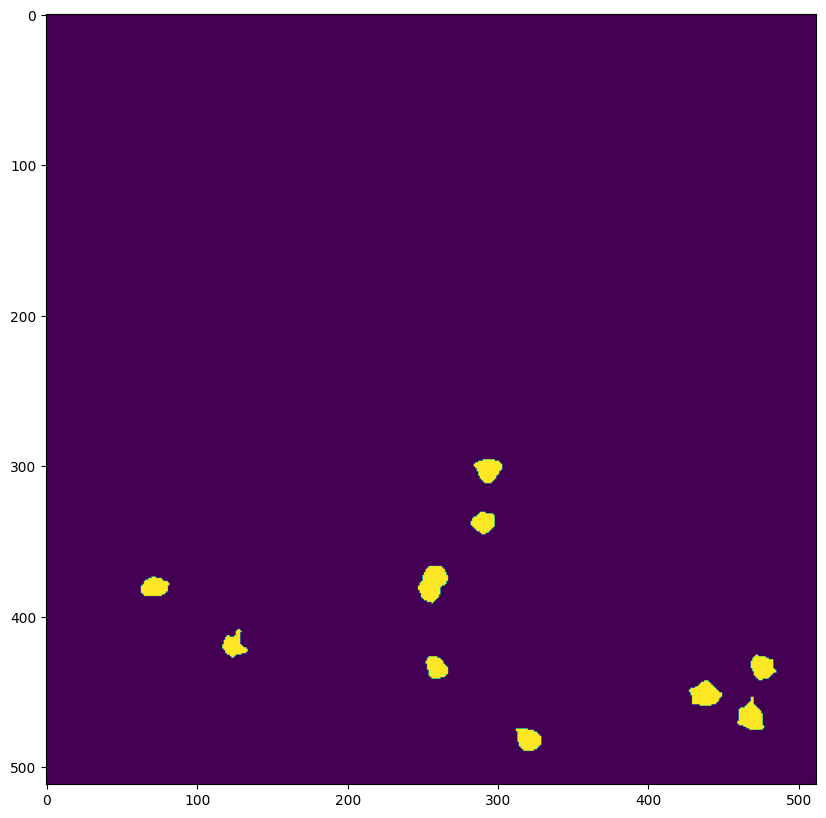

In [34]:
matrix = np.zeros((data["roi_masks"].shape[1], data["roi_masks"].shape[2]))
for roi in rois:
    x, y = np.where(data["roi_masks"][roi, :, :] != 0)
    matrix[x, y] = 1
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(matrix)

Colormap transparent: https://stackoverflow.com/questions/42481203/transparent-colormap-in-matplotlib

5
after: 1
5
after: 1
2
0
1
7
after: 3
0
4
after: 0
5
after: 1
4
after: 0
1


(512.0, 0.0)

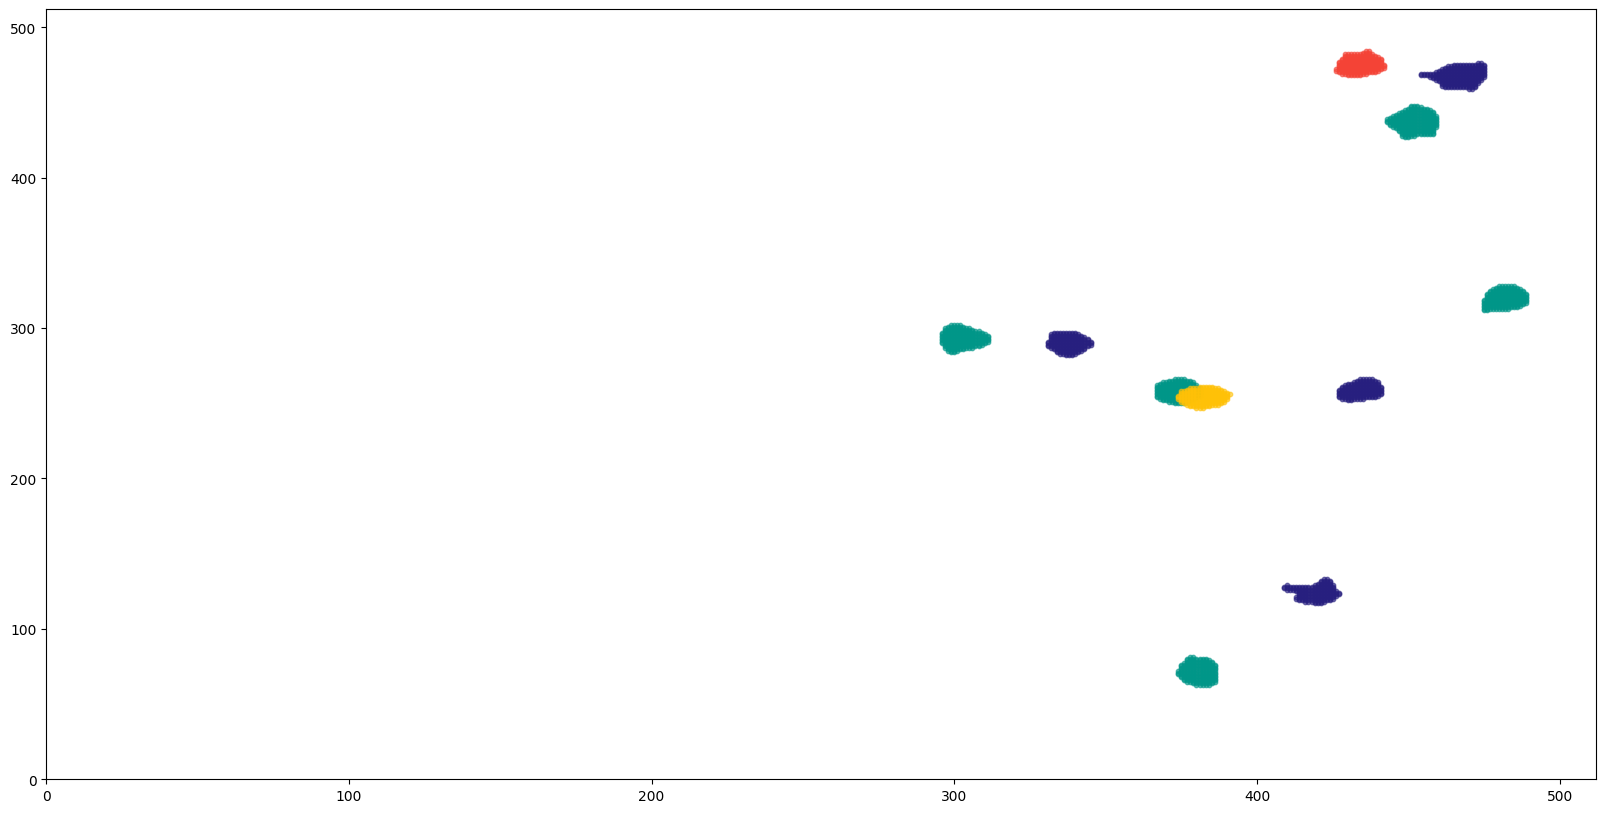

In [35]:
colors_list_masks = [
    "#271f7f",
    "#009688",
    "#ffc107",
    "#f44336",
]

fig, ax = plt.subplots(figsize=(20, 10))
for roi in rois:
    # plot the roi mask as scatter plot
    x, y = np.where(data["roi_masks"][roi, :, :] == 1)
    maxima_orientation = np.argmax(mean_spike_orientation[roi, :])
    print(maxima_orientation)
    if maxima_orientation > 3:
        maxima_orientation = maxima_orientation - 4
        print(f"after: {maxima_orientation}")

    ax.scatter(x, y, s=10, c=colors_list_masks[maxima_orientation], alpha=0.6)
    # invert the y axis

ax.set_xlim(0, 512)[::-1]
ax.set_ylim(0, 512)[::-1]

## Question

**Is there spatial structure in the preferred orientation/direction/spatial frequency?**

Implement all steps of the processing pipeline that are necessary to answer them. Think of: 
1. Pre-processing 
2. Spike inference 
3. Tuning function fitting 
3.5 Sort functions with zero entries, and little spikes out
4. Statistical testing. 
5. Temporal frequencies?
6. Do neighbouring cells share the same orientation?

It is sufficient to assess spatial structure visually. Bonus points for proper statistical assessment. Also bonus points if you focus on specific cell types.